In [1]:
import os
import itertools
import torch
import umap
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm import tqdm
from IPython.display import display, display_html
from torch.utils.data import DataLoader
from pandas.util import hash_pandas_object
from transformers import (
    DistilBertTokenizerFast, DistilBertModel, DistilBertForMaskedLM, 
    DistilBertForSequenceClassification, DataCollatorForLanguageModeling,
    Trainer, TrainingArguments, AutoTokenizer, set_seed, AdamW
)
from transformers.trainer_utils import get_last_checkpoint
from datasets import Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from movie_prediction.models import DistilBertForPrincipalPrediction
from movie_prediction.data_loaders.processed import load_principal_movie_lines
from movie_prediction.utils import sanitize_string_column
from movie_prediction.constants import *

In [2]:
torch.cuda.is_available()

True

In [3]:
t = torch.cuda.get_device_properties(0).total_memory
a = torch.cuda.memory_allocated(0)
r = torch.cuda.memory_reserved(0) 
f = r-a  # free inside reserved
f

0

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext movie_prediction
%reload_ext movie_prediction.constants
%reload_ext movie_prediction.models

In [5]:
sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.rcParams['font.size'] = 16

### Configuration

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

PRINCIPAL_LINES_CACHE_FP = DATA_DIR + '/' + PRINCIPALS_LINES_DEFAULT

### Load Processed Data

In [7]:
principal_lines = load_principal_movie_lines(cache_fp=PRINCIPAL_LINES_CACHE_FP)
principal_lines = principal_lines[principal_lines[UTTERANCE] != ' ']
principal_lines.head(2)

Creating principal movie lines dataset...
Loading principals Data...
Raw Number of Characters: 359009
Loading Characters Movie Lines Data...
Raw number of lines: 288613
Merging Principals and Character Lines...
Assigning Lines with Conflicting Principals...
Number of Ambiguous Principal Lines: 6558
Lines after principal merge: 160104 (55.47 %)
Exporting principal lines to: c:/users/corey/workspace/movie_prediction/data/principal_lines.tsv


,Line ID,Character,Title,Year,Utterance,Character (Raw),Character (First),Character (Last),Character (First+Last),Character (Full),Principal,Principal Lines
9861,56884,JACK,LEGEND,1985,No wait... please... listen...,JACK,JACK,None,None,JACK,THOMAS CRUISE MAPOTHER IV,1655
9862,56885,JACK,LEGEND,1985,Oh no... Don't you understand?,JACK,JACK,None,None,JACK,THOMAS CRUISE MAPOTHER IV,1655


### Check Utterance Length Distribution

<AxesSubplot:xlabel='Number of Words', ylabel='Frequency'>

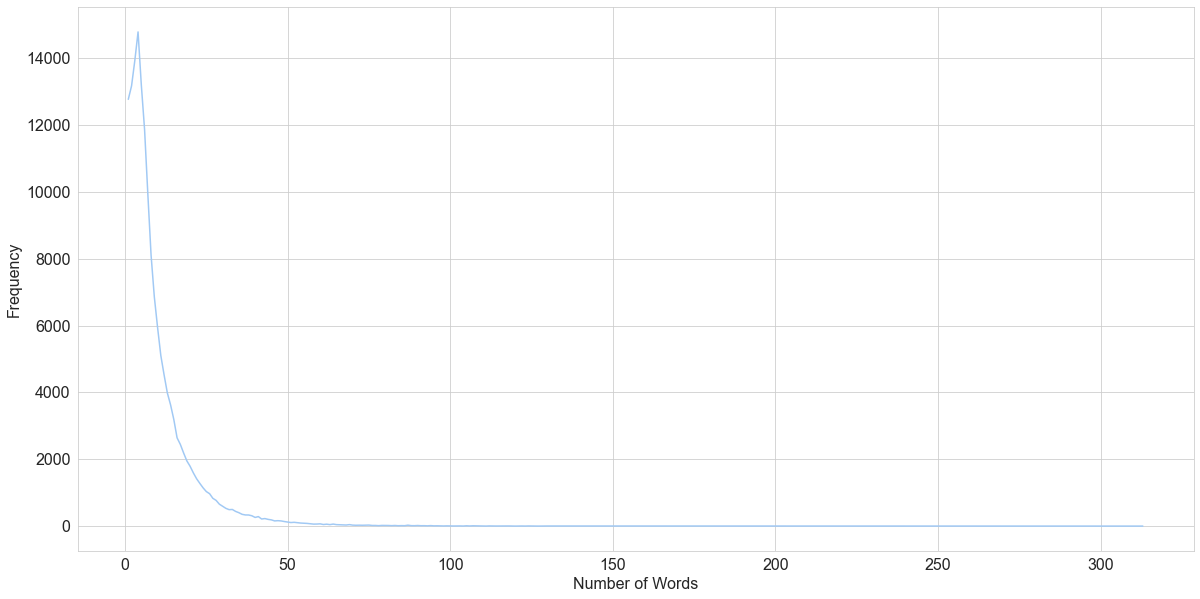

In [8]:
f, ax = plt.subplots(1, 1, figsize=(20,10)) 
words_dist = (principal_lines[UTTERANCE].str.count(' ') + 1).value_counts().reset_index().rename(
    columns={UTTERANCE: 'Frequency', 'index': 'Number of Words'}
).sort_values(by='Number of Words')
sns.lineplot(data=words_dist, x='Number of Words', y='Frequency', ax=ax)

It appears the number of words in a phrase tapers off dramatically after 75, therefore I will create a filter to limit the number of words in my dataset for optimization.

In [9]:
WORD_LIMIT = 75

too_many_words_filt = principal_lines[UTTERANCE].str.count(' ') > WORD_LIMIT

### Check for duplicated lines

In [10]:
principal_lines[UTTERANCE_SAN] = sanitize_string_column(principal_lines[UTTERANCE], upper=True, alphanumeric_only=True, whitespace=True)
principal_lines[UTTERANCE_HASH] = hash_pandas_object(principal_lines[UTTERANCE_SAN], index=False)

Duplicated Lines: 4747 (2.97 %)
Done


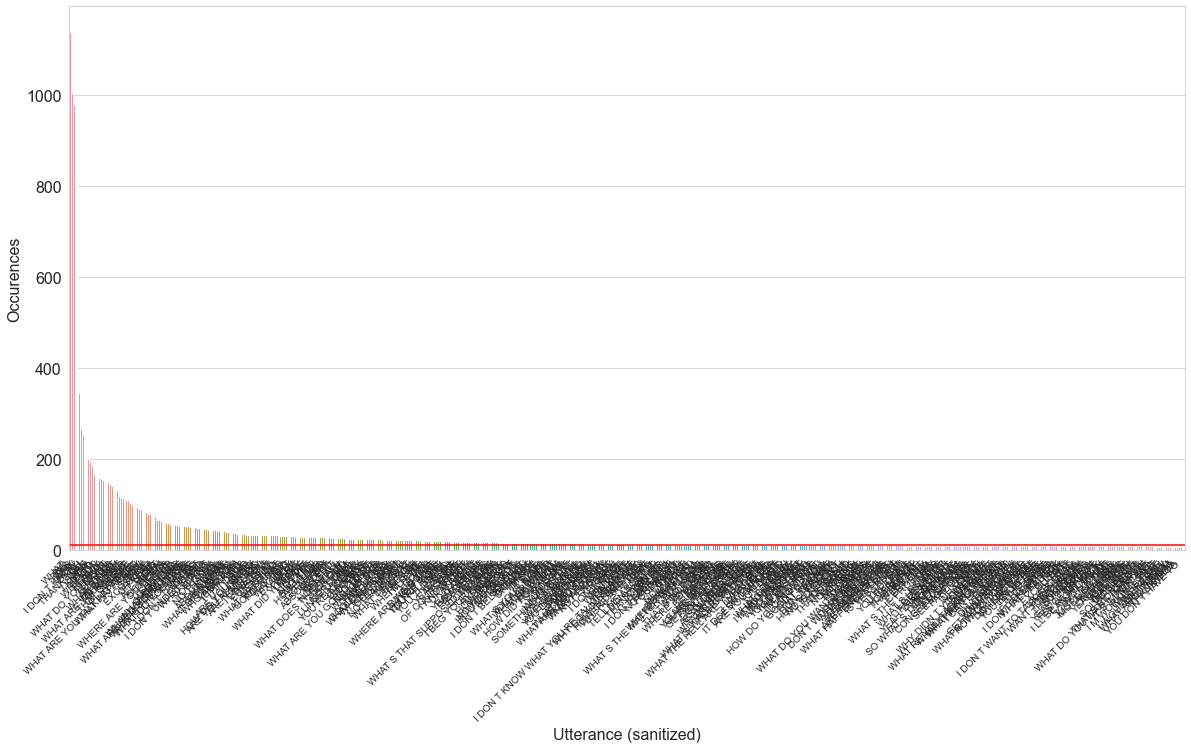

In [11]:
duplicated_lines = principal_lines[principal_lines[UTTERANCE_HASH].duplicated(keep=False)][UTTERANCE_SAN].value_counts().reset_index().rename(
    columns={UTTERANCE_SAN: 'Occurences', 'index': UTTERANCE_SAN})
print(f"Duplicated Lines: {len(duplicated_lines)} "
      f"({100 * len(duplicated_lines) / len(principal_lines):.2f} %)")

f, ax = plt.subplots(1, 1, figsize=(20,10)) 
sns.barplot(data=duplicated_lines[:500], x=UTTERANCE_SAN, y='Occurences', ax=ax)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Draw a line at 10 to threshold
ax.axhline(10.0, color='r')
print("Done")

There appears to be exponential decline. I will be able to build a crude common phrase filter from the phrases with occurences above the red line.

In [12]:
COMMON_PHRASE_THRESH = 10
common_phrase_filt = principal_lines[UTTERANCE_SAN].isin(
    duplicated_lines[
        duplicated_lines['Occurences'] > COMMON_PHRASE_THRESH
    ][UTTERANCE_SAN])

### Check if Problem Is Tractable 

In [13]:
# Initialize Tokenizer and Models
tokenizer = DistilBertTokenizerFast.from_pretrained(HUGGINGFACE_PRETRAINED)
model = DistilBertModel.from_pretrained(HUGGINGFACE_PRETRAINED)
model.to(device)
print("Done")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done


In [14]:
# Create Dataset
class PrincipalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, utterances, principals):
        self.encodings = encodings
        self.labels = labels
        self.utterances = utterances
        self.principals = principals
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['utterances'] = self.utterances[idx]
        item['principals'] = self.principals[idx]
        return item
    
    def __len__(self):
        return len(self.labels)

In [15]:
# Create Toy Dataset
toy_principals = ['THOMAS CRUISE MAPOTHER IV', 'THOMAS JEFFREY HANKS']
label_map = {k: i for i, k in enumerate(toy_principals)}
reverse_label_map = {v: k for k, v in label_map.items()}
toy_data = principal_lines[
    (principal_lines[PRINCIPAL].isin(toy_principals))
    & (~common_phrase_filt)
    & (~too_many_words_filt)
].drop_duplicates(subset=[UTTERANCE_HASH])
toy_dataset = PrincipalDataset(
    tokenizer(list(toy_data[UTTERANCE].astype(str)), padding=True, truncation=True, max_length=WORD_LIMIT),
    list(toy_data[PRINCIPAL].replace(label_map)),
    list(toy_data[UTTERANCE]),
    list(toy_data[PRINCIPAL])
)
toy_loader = DataLoader(toy_dataset, batch_size=32)

# Define function for retrieving embeddings
def get_embeddings(loader, model):
    model.eval()
    toy_embeddings = []
    all_labels = []
    utterances = []
    principals = []
    with torch.no_grad():
        for batch in tqdm(toy_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            toy_embeddings.append(outputs[0][:, 0])
            all_labels.append(labels)
            utterances.extend(batch['utterances'])
            principals.extend(batch['principals'])
            
    toy_embeddings = torch.cat(toy_embeddings).cpu().detach().numpy()
    all_labels = torch.cat(all_labels).cpu().detach().numpy()
    
    return toy_embeddings, all_labels, utterances, principals

# Get the embeddings and metadata
toy_embeddings, all_labels, utterances, principals = get_embeddings(toy_loader, model)

100%|███████████████████████████████████████████████████████████████████████████████| 74/74 [00:04<00:00, 15.73it/s]


In [16]:
# Project Data to Two Dimensions 
scaled_toy_embeddings = StandardScaler().fit_transform(toy_embeddings)
reducer = umap.UMAP(random_state=42, metric='euclidean', n_neighbors=15, min_dist=0.0)
visualization = reducer.fit_transform(scaled_toy_embeddings)
visualization = pd.concat([
    pd.DataFrame(visualization, columns=['x', 'y']),
    pd.DataFrame({PRINCIPAL: principals, UTTERANCE: utterances})
], axis=1)

# Calculate a distance metric between the two dimensions
visualization['Distance'] = (visualization['x'] - visualization['y']).abs()
visualization.sort_values(by='Distance')

,x,y,Principal,Utterance,Distance
1346,8.455265,8.453489,THOMAS CRUISE MAPOTHER IV,No you're not in trouble. I'm interested in a ...,0.001776
2135,8.556140,8.562123,THOMAS JEFFREY HANKS,I know. But she's here Jonah. Because I have y...,0.005983
1303,8.394876,8.401794,THOMAS CRUISE MAPOTHER IV,You were right. I'm not being set up.,0.006918
2084,8.344660,8.355392,THOMAS JEFFREY HANKS,I'm probably not interested in whatever you're...,0.010733
1913,8.140955,8.160321,THOMAS JEFFREY HANKS,You fucked us over.,0.019366
...,...,...,...,...,...
1397,11.945088,6.079327,THOMAS CRUISE MAPOTHER IV,Georgetown.,5.865761
956,11.892617,6.004496,THOMAS CRUISE MAPOTHER IV,From '84 to '89.,5.888121
1117,12.089959,6.174650,THOMAS CRUISE MAPOTHER IV,Ninety-seven minutes twenty-seven seconds.,5.915309
1039,12.169655,6.215835,THOMAS CRUISE MAPOTHER IV,Five six-hundred thousand.,5.953820


<AxesSubplot:xlabel='x', ylabel='y'>

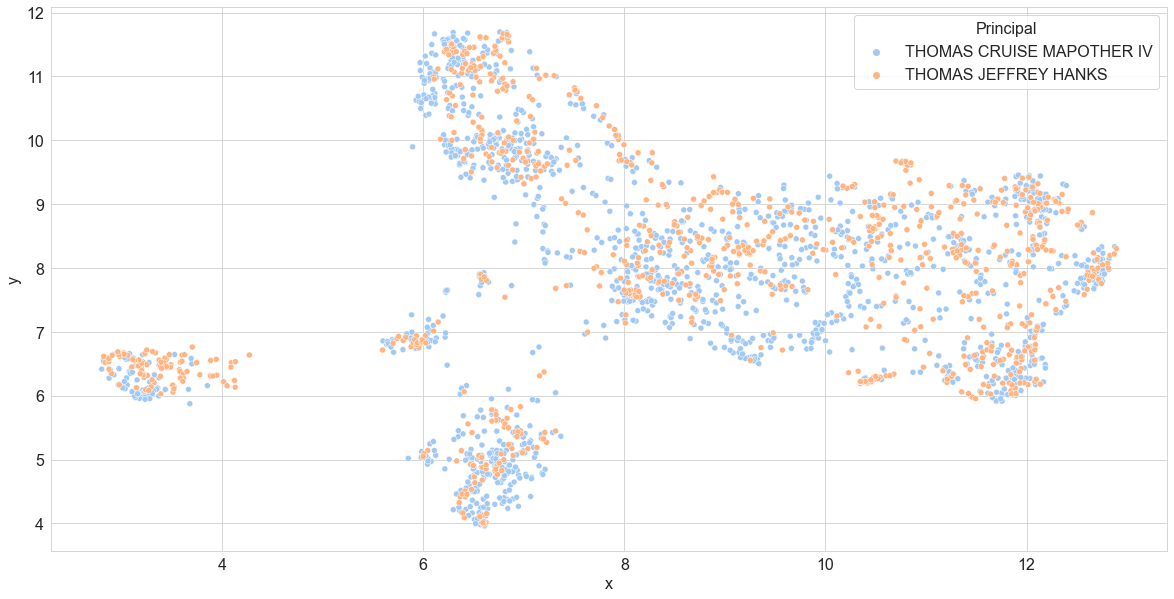

In [17]:
f, ax = plt.subplots(1, 1, figsize=(20,10))
sns.scatterplot(data=visualization, x='x', y='y', hue=PRINCIPAL, ax=ax)

The problem may be somewhat tractible but the model may benefit from some fine tuning on our dataset.

### Fine Tune Language Model

In [18]:
# Export Lines to a readable dataset
LM_DATASET = DATA_DIR + '/principal_lines.txt'
EXPORT_LINES = False

if EXPORT_LINES:
    principal_lines[
        (~common_phrase_filt) 
        & (~too_many_words_filt)
    ][UTTERANCE].to_csv(LM_DATASET, index=False, header=False)

In [19]:
# Configuration
LM_DIR = MODEL_DIR + '/' + MOVIE_TUNED
OVERWRITE = True
MASKING_PROBABILITY = 0.15
TUNE_LANGUAGE_MODEL = False

if TUNE_LANGUAGE_MODEL:

    # Load pretrained model in language model format
    model = DistilBertForMaskedLM.from_pretrained(PRETRAINED_MODEL)
    tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL, use_fast=True, cache_dir='../models/cache')
    model.resize_token_embeddings(len(tokenizer))

    # Get checkpoint if available
    last_checkpoint = None
    if os.path.isdir(LM_DIR) and not OVERWRITE:
        last_checkpoint = get_last_checkpoint(LM_DIR)

    # Set seed before initializing model.
    set_seed(42)

    # Tokenize utterances data
    def tokenize_function(examples):
        return tokenizer(
            examples[UTTERANCE],
            padding=True,
            truncation=True,
            return_special_tokens_mask=True,
            max_length=WORD_LIMIT
        )
    
    dataset = Dataset.from_pandas(principal_lines[~common_phrase_filt][UTTERANCE].to_frame())
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        load_from_cache_file=True,
        remove_columns=[UTTERANCE]
    )

    # Collator for masking tokens 
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm_probability=MASKING_PROBABILITY,
        pad_to_multiple_of=None
    )

    # Train model
    trainer = Trainer(
        model=model,
        train_dataset=dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        args=TrainingArguments(
            output_dir=LM_DIR, 
            overwrite_output_dir=OVERWRITE, 
            do_train=True,
        )
    )
    train_result = trainer.train(resume_from_checkpoint=last_checkpoint)
    trainer.save_model()


    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()

Some weights of the model checkpoint at c:/users/corey/workspace/movie_prediction/models/distilbert-base-uncased-movie-tuned were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████| 74/74 [00:04<00:00, 16.47it/s]


<AxesSubplot:xlabel='x', ylabel='y'>

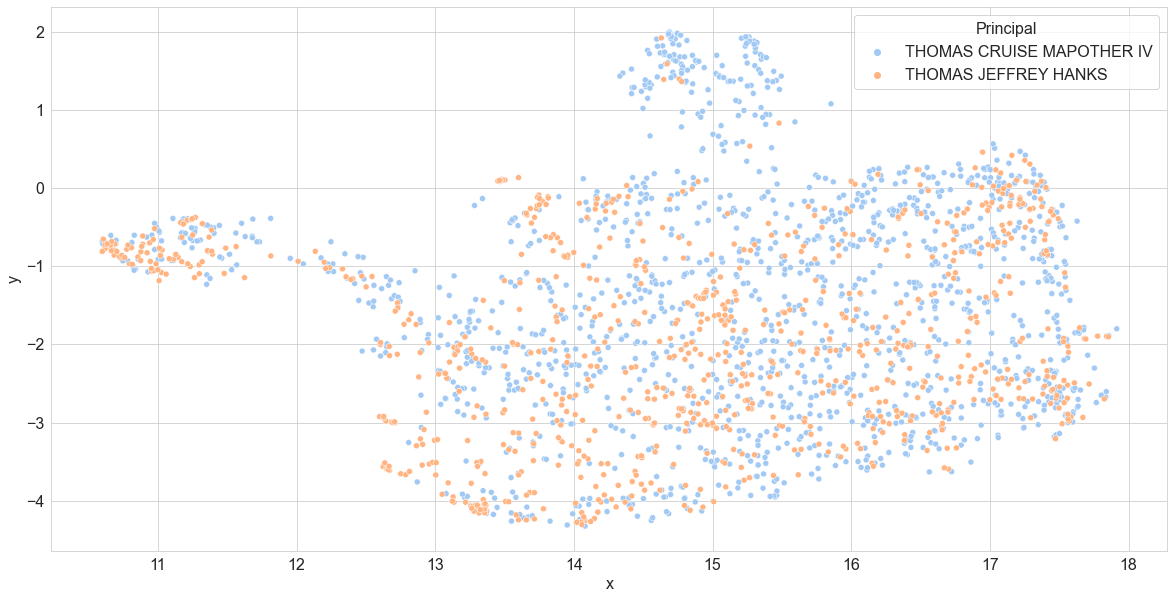

In [20]:
# Load Tuned Language model
model = DistilBertModel.from_pretrained(LM_DIR)
model.to(device)

# Get the tuned embeddings and metadata
toy_embeddings, all_labels, utterances, principals = get_embeddings(toy_loader, model)

# Project Data to Two Dimensions 
scaled_toy_embeddings = StandardScaler().fit_transform(toy_embeddings)
reducer = umap.UMAP(random_state=42, metric='euclidean', n_neighbors=15, min_dist=0.0)
visualization = reducer.fit_transform(scaled_toy_embeddings)
visualization = pd.concat([
    pd.DataFrame(visualization, columns=['x', 'y']),
    pd.DataFrame({PRINCIPAL: principals, UTTERANCE: utterances})
], axis=1)

f, ax = plt.subplots(1, 1, figsize=(20,10))
sns.scatterplot(data=visualization, x='x', y='y', hue=PRINCIPAL, ax=ax)

### Check Principal Distribution

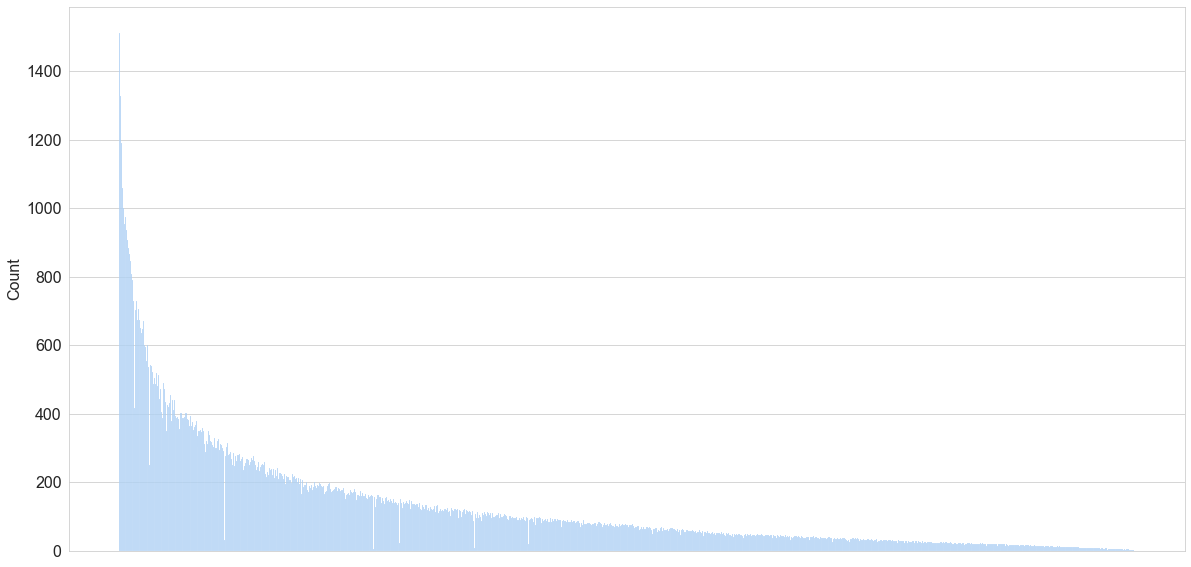

In [21]:
f, ax = plt.subplots(1, 1, figsize=(20,10))
sns.histplot(principal_lines[
    (~common_phrase_filt)
    & (~too_many_words_filt)
][PRINCIPAL], ax=ax)
ax.xaxis.set_ticklabels([])
ax.get_xaxis().set_visible(False)

It appears a to be a steep drop off of data after the top principals. 
Setting a limit of the top 25 principals will yield us a dataset with enough data to train a model. We will need to 

In [22]:
principal_counts = principal_lines[(~common_phrase_filt)
    & (~too_many_words_filt)][PRINCIPAL].value_counts().head(25).to_frame()
df1_styler = principal_counts.style.set_table_attributes("style='display:inline'").set_caption('Principal Counts')
principal_cum_counts = principal_lines[(~common_phrase_filt)
    & (~too_many_words_filt)][PRINCIPAL].value_counts().cumsum().head(25).to_frame()
df2_styler = principal_cum_counts.style.set_table_attributes("style='display:inline'").set_caption('Principal Counts (Cumulative)')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,Principal
THOMAS CRUISE MAPOTHER IV,1512
NICHOLAS KIM COPPOLA,1328
DUSTIN LEE HOFFMAN,1191
JOHN CHRISTOPHER DEPP II,1061
ALFREDO JAMES PACINO,1000
JOHN JOSEPH NICHOLSON,983
JULIA FIONA ROBERTS,976
JOHN PAUL CUSACK,954
MICHAEL KIRK DOUGLAS,938
SYLVESTER ENZIO STALLONE,908


In [23]:
principals_to_predict = list(principal_lines[
    (~common_phrase_filt)
    & (~too_many_words_filt)][PRINCIPAL].value_counts().index.values[:25])
predicted_principals_filt = principal_lines[PRINCIPAL].isin(principals_to_predict)

# Train Principal Prediction Model

In [24]:
# Establish Label maps
label_map = {k: i for i, k in enumerate(principals_to_predict)}
reverse_label_map = {v: k for k, v in label_map.items()}

# Setup dataset
dataset = principal_lines[
    (predicted_principals_filt)
    & (~common_phrase_filt)
    & (~too_many_words_filt)
].drop_duplicates(subset=[UTTERANCE_HASH])

outputs = dataset[PRINCIPAL].replace(label_map)
train_utts, val_utts, train_labels, val_labels = train_test_split(
    dataset[UTTERANCE_SAN], 
    pd.get_dummies(outputs).astype(float).to_numpy(), 
    test_size=0.2
) 
train_encodings, val_encodings = tokenizer(list(train_utts.astype(str)), **TOKENIZER_ARGS_DEFAULT), tokenizer(list(val_utts.astype(str)), **TOKENIZER_ARGS_DEFAULT)

train_dataset = PrincipalDataset(
    train_encodings, train_labels, train_utts.values, 
    pd.Series(np.argmax(train_labels, axis=1)).replace(reverse_label_map))
val_dataset = PrincipalDataset(
    val_encodings, val_labels, val_utts.values, 
    pd.Series(np.argmax(train_labels, axis=1)).replace(reverse_label_map))

In [25]:
# Get class weights 
class_weights = torch.tensor(
    class_weight.compute_class_weight('balanced', classes=np.unique(outputs), y=outputs), 
).to(device)

# Setup Model Using Tuned Lanaguage Model
PRINC_PRED_DIR = MODEL_DIR + '/' + PRINC_PRED_MODEL_TUNED
model = DistilBertForPrincipalPrediction.from_pretrained(LM_DIR, id2label=reverse_label_map, label2id=label_map)

# Overwrite default configs
model.classifier.out_features = len(label_map)
model.class_weights = class_weights

# Ensure we don't update the transformer weights
for param in model.distilbert.parameters():
    param.requires_grad = False
model.train()

# Setup training
training_args = TrainingArguments(
    output_dir=PRINC_PRED_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    logging_dir='../logs/principal-prediction',
    logging_steps=500,
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=5e-4,
    save_total_limit=5
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train and save 
train_results = trainer.train()
model.save_pretrained(PRINC_PRED_DIR)

Some weights of the model checkpoint at c:/users/corey/workspace/movie_prediction/models/distilbert-base-uncased-movie-tuned were not used when initializing DistilBertForPrincipalPrediction: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForPrincipalPrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForPrincipalPrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForPrincipalPrediction were not initialized from the model checkpoint at c:/users/corey/workspace/movie_prediction/models/distilber

Epoch,Training Loss,Validation Loss
1,0.165200,0.164248
2,0.160800,0.161704
3,0.158400,0.160445


# Test Model

In [27]:
train_df = pd.concat([
    pd.DataFrame(train_utts.rename(UTTERANCE_SAN)).reset_index(drop=True), 
    pd.DataFrame(pd.Series(np.argmax(train_labels, axis=1)).replace(reverse_label_map).rename(PRINCIPAL))
], axis=1)
val_df = pd.concat([
    pd.DataFrame(val_utts.rename(UTTERANCE_SAN)).reset_index(drop=True), 
    pd.DataFrame(pd.Series(np.argmax(val_labels, axis=1)).replace(reverse_label_map).rename(PRINCIPAL))
], axis=1)

tokenizer_args = { 'padding': True, 'truncation': True, 'max_length': WORD_LIMIT }
tokenizer = DistilBertTokenizerFast.from_pretrained(HUGGINGFACE_PRETRAINED)
model = DistilBertForPrincipalPrediction.from_pretrained(PRINC_PRED_DIR)
model.to(device)
model.eval()
print("Done")

Done


In [28]:
def predict_principals(
    sample_utt, tokenizer, model, 
    tokenizer_args=TOKENIZER_ARGS_DEFAULT):
    
    # Tokenizer and send to device
    input_ids, attention_mask = tokenizer([sample_utt], **tokenizer_args).values()
    input_ids, attention_mask = torch.tensor(input_ids).to(device), torch.tensor(attention_mask).to(device)
    
    # Predict
    predicted_output = torch.softmax(
        model(input_ids, attention_mask)[0].squeeze(), dim=0).cpu().detach().tolist()
    
    # Beautify
    predicted_output = {model.config.id2label[i]: v for i, v in enumerate(predicted_output)}
    predicted_output = {
        k: v 
        for k, v in sorted(
            predicted_output.items(), key=lambda x: x[1], 
            reverse=True)
    }
    
    return predicted_output

In [29]:
# Test individual utterances from set
train_sample_utt, train_sample_principal = train_df.sample(1).iloc[0]
val_sample_utt, val_sample_principal = val_df.sample(1).iloc[0]

print(f"Sample Training Utterance: {train_sample_utt}")
print(f"Expected Training Principal: {train_sample_principal}")
print("")
print(f"Sample Validation Utterance: {val_sample_utt}") 
print(f"Expected Validation Principal: {val_sample_principal}")
train_pred = predict_principals(train_sample_utt, tokenizer, model)
val_pred = predict_principals(val_sample_utt, tokenizer, model)
train_styler = pd.DataFrame.from_dict(
    train_pred, orient='index').style.set_table_attributes("style='display:inline'").set_caption('Train Sample Probabilities')
val_styler = pd.DataFrame.from_dict(
    val_pred, orient='index').style.set_table_attributes("style='display:inline'").set_caption('Val Sample Probabilities')
display_html(train_styler._repr_html_()+val_styler._repr_html_(), raw=True)

Sample Training Utterance: YOUR AUNT 
Expected Training Principal: MICHAEL KIRK DOUGLAS

Sample Validation Utterance:  WE CAN T STAY HERE I CAN T STAY HERE IT S NOT SAFE HERE 
Expected Validation Principal: MATTHEW PAIGE DAMON


,0
MICHAEL KIRK DOUGLAS,0.062732
JOHN JOSEPH NICHOLSON,0.060394
GEORGE TIMOTHY CLOONEY,0.053109
WILLIAM BRADLEY PITT,0.052437
DUSTIN LEE HOFFMAN,0.051222
NICHOLAS KIM COPPOLA,0.050495
THOMAS CRUISE MAPOTHER IV,0.047516
ALFREDO JAMES PACINO,0.047347
JAMES MAITLAND STEWART,0.043646
PHILIP ANTHONY HOPKINS,0.043621


# Check Classifier Weights

In [30]:
pre_clasiffier_weights = list(model.pre_classifier.parameters())[0].data.flatten().cpu().numpy()
clasiffier_weights = list(model.classifier.parameters())[0].data.flatten().cpu().numpy()

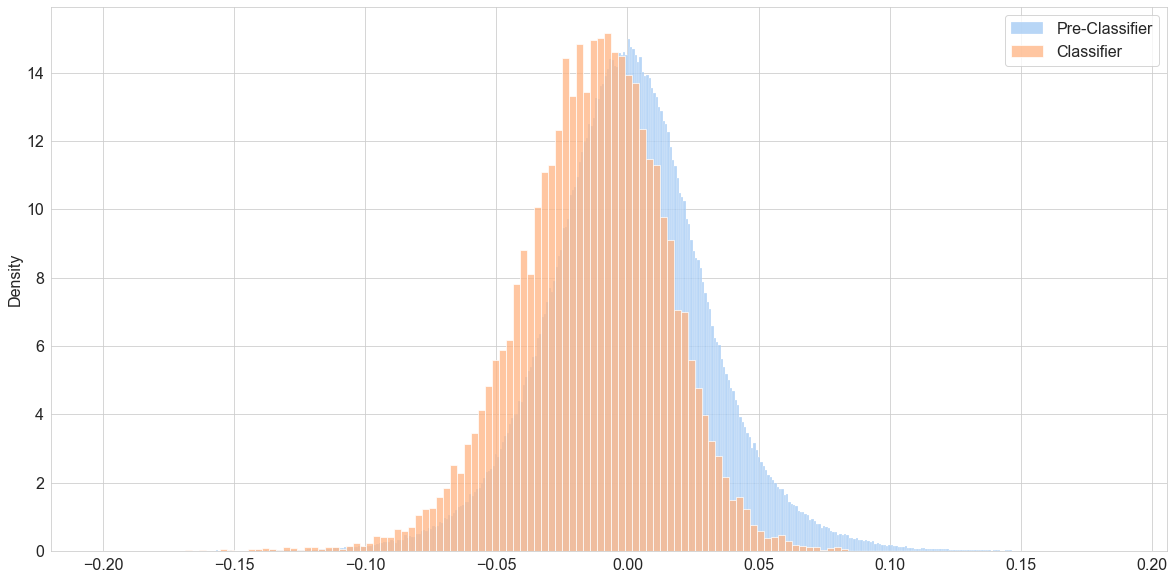

In [31]:
f, ax = plt.subplots(1, 1, figsize=(20,10))
palette = itertools.cycle(sns.color_palette())
sns.histplot(pre_clasiffier_weights, stat='density', color=next(palette))
sns.histplot(clasiffier_weights, stat='density', color=next(palette))
ax.legend(['Pre-Classifier', 'Classifier'])

The negative skew on the final layer classifier weights is symptomatic of the model struggling to predict with high confidence which principal said the utterance (negative logits produce smaller values after the sigmoid transform). 